# Dimensionality Reduction Notebook
In this notebook I'm running the dimensionality reduction and feature analysis process of the extracted features dataset.

**Author**: Arthur G.
***

## Loading Dependencies
In this section I'm loading and setting up the dependencies for this notebook.

In [1]:
# libs
import os
import typing as t

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# settings
seed = 42
sns.set_style("ticks")
sns.set_palette(["#377eb8", "#ff7f00", "#4daf4a", "#984ea3", "#e41a1c", "#dede00"])

## Helper Functions
In this section I'm writing a set of helper functions to automate dimensionality reduction.

In [2]:
def plot_feature_ranking(
    datasets_list: np.ndarray,
    n_components: int = 20,
    figsize: tuple = (7, 7),
    seed: int = seed
) -> None:
    """
    Calculate feature ranks for all datasets passed as argument
    and then plots in one figure with subplots.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    sns.set(style="ticks")
    
    for i, (X, y) in enumerate(datasets_list):
        clf = RandomForestClassifier(random_state=seed)
        clf.fit(X, y)

        importance_scores = clf.feature_importances_
        feature_names = [f"{i}" for i in range(len(importance_scores))]

        df = pd.DataFrame({'Feature': feature_names, 'Importance Score': importance_scores})
        df = df.sort_values('Importance Score', ascending=False).head(n_components)

        ax = axes[i // 2, i % 2]
        sns.barplot(x='Importance Score', y='Feature', data=df, ax=ax)
        ax.set(xlabel='', ylabel='')
        ax.set_title("")

    plt.tight_layout(pad=3.)
    plt.show()
    

def select_ranked_features(data: pd.DataFrame, target: np.ndarray, num_features: int) -> list:
    """
    Implements feature selection using ranks calculated by RandomForestClassifier.
    """
    # initializing classifier
    clf = RandomForestClassifier()
    clf.fit(data, target)

    # extracting best features
    feature_importances = clf.feature_importances_
    top_feature_indices = np.argsort(feature_importances)[::-1][:num_features]

    return data.columns[top_feature_indices]
    
def tsne_low_dimensional_plot(datasets: list[np.ndarray], target: np.ndarray, figsize: tuple = (15, 10)) -> None:
    """
    Plots the projection of the given datasets into a low-dimensional space
    using t-SNE.
    """
    num_datasets = len(datasets)
    num_rows = 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, dataset in enumerate(datasets):
        tsne = TSNE(n_components=2)
        transformed_data = tsne.fit_transform(dataset)

        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        ax.set_title("")
        scatter = sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=target, ax=ax)
        scatter.legend_.remove()
        sns.despine()

    # Remove empty subplots if the number of datasets is less than 4
    if num_datasets < num_rows * num_cols:
        for i in range(num_datasets, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col])

    plt.tight_layout(pad=3.)
    plt.show()

def apply_tsen_dimensionality_reduction(
    data: np.ndarray,
    n_components: int,
    seed: int = seed
) -> t.Tuple[t.Any, t.Any]:
    """
    Applies t-SNE for dimensionality reduction.
    """
    tsne_embedding = TSNE(n_components=n_components, method="exact", random_state=seed)
    reduced_data = tsne_embedding.fit_transform(data)
    
    return tsne_embedding, reduced_data

## Loading Datasets
In this section I'm loading the augmented image dataset.

In [3]:
data = np.load(os.path.join("..", "data", "finalized", "augmented_images_features_dataset.npz"))
target = np.ravel(data["train_targets"])

## t-SNE Low-Dimensional Plot
In this section I'm plotting the low-dimensional version of each dataset using the t-SNE plot.

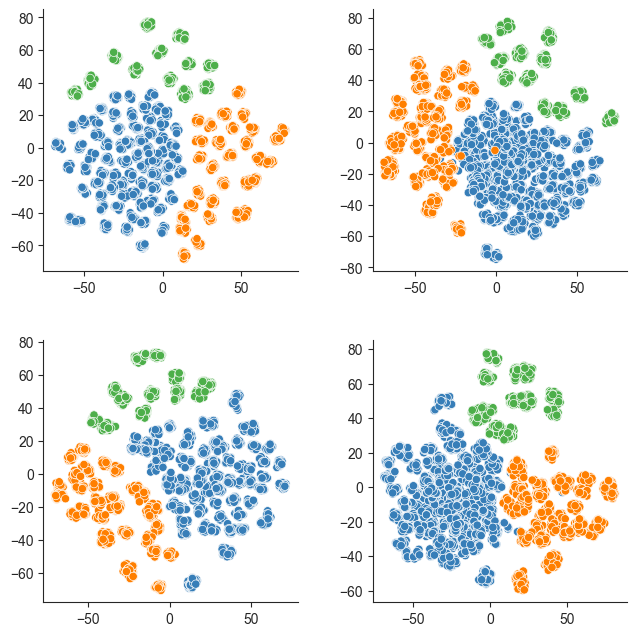

In [4]:
categorical_target_array = np.where(
    target == 0, 'Anolis',
    np.where(target == 1, 'Hoplocercus', 'Polychrus')
)

tsne_low_dimensional_plot(
    datasets=[
        data["v1_train_features"],
        data["v2_train_features"],
        data["v3_large_train_features"],
        data["v3_small_train_features"]
    ],
    target=np.ravel(categorical_target_array),
    figsize=(7, 7)
)

## Feature Ranks
In this section I'm using a Random Forest Classifier for calculating feature ranks in order to select a subset of the features selected by the Explained Variance.

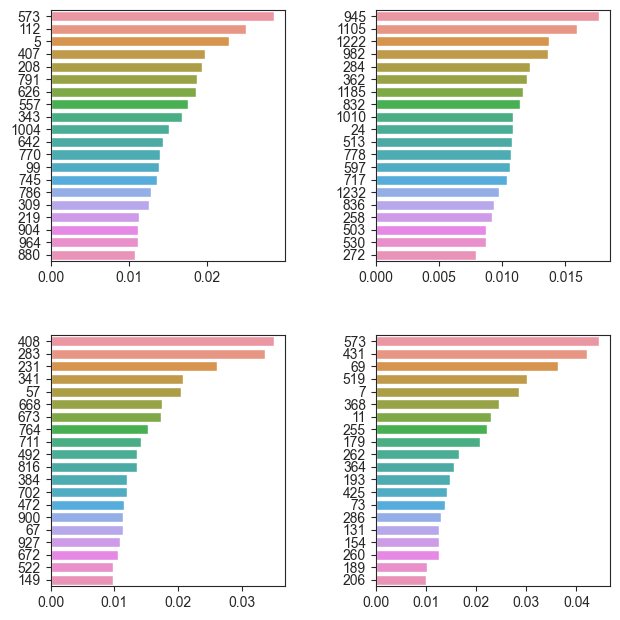

In [5]:
plot_feature_ranking(
    datasets_list=[
        (data["v1_train_features"], np.ravel(target)),
        (data["v2_train_features"], np.ravel(target)),
        (data["v3_large_train_features"], np.ravel(target)),
        (data["v3_small_train_features"], np.ravel(target))
    ],
    n_components=20,
    figsize=(7, 7)
)

## Selecting Best N Ranked Features
Using the best N ranked features for creating the reduced dataset.

In [6]:
# turning data matrices into dataframes
v1_train_features = pd.DataFrame(data["v1_train_features"])
v2_train_features = pd.DataFrame(data["v2_train_features"])
v3_large_train_features = pd.DataFrame(data["v3_large_train_features"])
v3_small_train_features = pd.DataFrame(data["v3_small_train_features"])

v1_test_features = pd.DataFrame(data["v1_test_features"])
v1_valid_features = pd.DataFrame(data["v1_valid_features"])
v2_test_features = pd.DataFrame(data["v2_test_features"])
v2_valid_features = pd.DataFrame(data["v2_valid_features"])
v3_large_test_features = pd.DataFrame(data["v3_large_test_features"])
v3_large_valid_features = pd.DataFrame(data["v3_large_valid_features"])
v3_small_test_features = pd.DataFrame(data["v3_small_test_features"])
v3_small_valid_features = pd.DataFrame(data["v3_small_valid_features"])


# selecting best features
v1_best_features_names = select_ranked_features(v1_train_features, target=target, num_features=20)
v1_train_best_features = v1_train_features[v1_best_features_names]
v1_test_best_features = v1_test_features[v1_best_features_names]
v1_valid_best_features = v1_valid_features[v1_best_features_names]

v2_best_features_names = select_ranked_features(v2_train_features, target=target, num_features=20)
v2_train_best_features = v2_train_features[v2_best_features_names]
v2_test_best_features = v2_test_features[v2_best_features_names]
v2_valid_best_features = v2_valid_features[v2_best_features_names]

v3_large_best_features_names = select_ranked_features(v3_large_train_features, target=target, num_features=20)
v3_large_train_features = v3_large_train_features[v3_large_best_features_names]
v3_large_test_features = v3_large_test_features[v3_large_best_features_names]
v3_large_valid_features = v3_large_valid_features[v3_large_best_features_names]

v3_small_best_features_names = select_ranked_features(v3_small_train_features, target=target, num_features=20)
v3_small_train_features = v3_small_train_features[v3_small_best_features_names]
v3_small_test_features = v3_small_test_features[v3_small_best_features_names]
v3_small_valid_features = v3_small_valid_features[v3_small_best_features_names]

## Data Serialization
In this last section I'm serialized the datasets reduced by t-SNE.

In [8]:
# reduced features datasets
np.savez(
    os.path.join("..", "data", "finalized", "augmented_image_best_features_dataset.npz"),
    v1_train_best_features=v1_train_best_features.to_numpy(),
    v1_test_best_features=v1_test_best_features.to_numpy(),
    v1_valid_best_features=v1_valid_best_features.to_numpy(),
    v2_train_best_features=v2_train_best_features.to_numpy(),
    v2_test_best_features=v2_test_best_features.to_numpy(),
    v2_valid_best_features=v2_valid_best_features.to_numpy(),
    v3_large_train_features=v3_large_train_features.to_numpy(),
    v3_large_test_features=v3_large_test_features.to_numpy(),
    v3_large_valid_features=v3_large_valid_features.to_numpy(),
    v3_small_train_features=v3_small_train_features.to_numpy(),
    v3_small_test_features=v3_small_test_features.to_numpy(),
    v3_small_valid_features=v3_small_valid_features.to_numpy(),
    target_column=target
)